In [1]:
import torch
import torchvision
import os
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

In [2]:
class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.base_dir = base_dir
        self.transform = transform
        self.data = []
        categories = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']

        for idx, category in enumerate(categories):
            path = os.path.join(base_dir, category)
            images = os.listdir(path)[:1000]  # Take only 1000 images per category
            for image in images:
                self.data.append((os.path.join(path, image), idx))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Assuming 'base_dir' is your dataset directory path
base_dir = 'data/gaussian_filtered_images/gaussian_filtered_images/'  # Update this path
dataset = DiabeticRetinopathyDataset(base_dir=base_dir, transform=transform)

# Splitting the dataset into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

def modify_efficientnet(model_name, num_classes=5):
    model = getattr(models, model_name)(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(num_features, num_classes)
    )
    return model

In [5]:
def train_and_evaluate(model, criterion, optimizer, scheduler, train_loader, val_loader, device, epochs=10):
    best_val_loss = float('inf')
    patience = 3
    patience_counter = 0

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        scheduler.step()
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        # Early stopping and saving the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{model_name}_best.pth")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Stopping early at epoch {epoch+1}")
                break

        print(f'{model_name} - Epoch {epoch+1}, Train Loss: {train_loss}, ' +
              f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}%')

    return train_losses, val_losses, val_accuracies

In [6]:
efficientnet_variants = ['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 
                         'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 
                         'efficientnet_b6']

In [7]:
all_train_losses = []
all_val_losses = []

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = 5

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from matplotlib import pyplot as plt

def evaluate_performance(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    display = ConfusionMatrixDisplay(confusion_matrix=cm)
    display.plot(cmap=plt.cm.Blues)
    plt.show()

efficientnet_b0 - Epoch 1, Train Loss: 1.0976735254128773, Validation Loss: 0.8897959391276041, Validation Accuracy: 66.08391608391608%
efficientnet_b0 - Epoch 2, Train Loss: 0.8861706132690111, Validation Loss: 0.8195918500423431, Validation Accuracy: 68.88111888111888%
efficientnet_b0 - Epoch 3, Train Loss: 0.8361058831214905, Validation Loss: 0.7888055311308967, Validation Accuracy: 68.7062937062937%
efficientnet_b0 - Epoch 4, Train Loss: 0.7936815636025535, Validation Loss: 0.7760203447606828, Validation Accuracy: 69.75524475524476%
efficientnet_b0 - Epoch 5, Train Loss: 0.7736926111910079, Validation Loss: 0.7692292763127221, Validation Accuracy: 69.23076923076923%
efficientnet_b0 - Epoch 6, Train Loss: 0.7515821643173695, Validation Loss: 0.7616419593493143, Validation Accuracy: 69.05594405594405%
efficientnet_b0 - Epoch 7, Train Loss: 0.7355429906811979, Validation Loss: 0.7457123862372504, Validation Accuracy: 70.27972027972028%
efficientnet_b0 - Epoch 8, Train Loss: 0.70023033

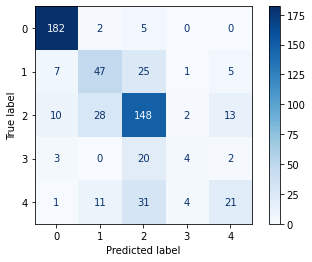

efficientnet_b1 - Epoch 1, Train Loss: 1.0859626688890986, Validation Loss: 0.8964110679096646, Validation Accuracy: 69.05594405594405%
efficientnet_b1 - Epoch 2, Train Loss: 0.8728308462434344, Validation Loss: 0.8385975658893585, Validation Accuracy: 68.7062937062937%
efficientnet_b1 - Epoch 3, Train Loss: 0.809698169430097, Validation Loss: 0.8180359337064955, Validation Accuracy: 67.83216783216783%
efficientnet_b1 - Epoch 4, Train Loss: 0.7966897429691421, Validation Loss: 0.798817601468828, Validation Accuracy: 70.1048951048951%
efficientnet_b1 - Epoch 5, Train Loss: 0.7586894921130605, Validation Loss: 0.7795748942428165, Validation Accuracy: 69.4055944055944%
efficientnet_b1 - Epoch 6, Train Loss: 0.7655392727918096, Validation Loss: 0.7800922128889296, Validation Accuracy: 69.4055944055944%
efficientnet_b1 - Epoch 7, Train Loss: 0.7309404619865947, Validation Loss: 0.7614472475316789, Validation Accuracy: 70.27972027972028%
efficientnet_b1 - Epoch 8, Train Loss: 0.7047113254666

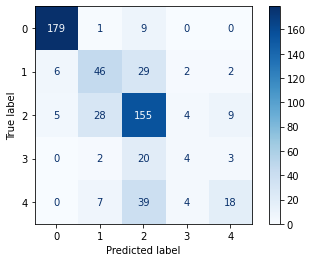

efficientnet_b2 - Epoch 1, Train Loss: 1.0992465292414029, Validation Loss: 0.9255404406123691, Validation Accuracy: 65.55944055944056%
efficientnet_b2 - Epoch 2, Train Loss: 0.8936107754707336, Validation Loss: 0.8549923002719879, Validation Accuracy: 66.60839160839161%
efficientnet_b2 - Epoch 3, Train Loss: 0.8432605109281011, Validation Loss: 0.8499741786056094, Validation Accuracy: 67.48251748251748%
efficientnet_b2 - Epoch 4, Train Loss: 0.8016710695293214, Validation Loss: 0.8267796271377139, Validation Accuracy: 66.43356643356644%
efficientnet_b2 - Epoch 5, Train Loss: 0.7890999399953418, Validation Loss: 0.8300838106208377, Validation Accuracy: 66.25874125874125%
efficientnet_b2 - Epoch 6, Train Loss: 0.7489706360631518, Validation Loss: 0.8187921610143449, Validation Accuracy: 66.25874125874125%
efficientnet_b2 - Epoch 7, Train Loss: 0.7511859134667449, Validation Loss: 0.8020502991146512, Validation Accuracy: 69.05594405594405%
efficientnet_b2 - Epoch 8, Train Loss: 0.7212559

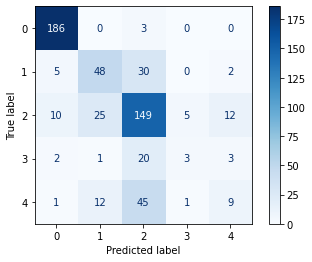

efficientnet_b3 - Epoch 1, Train Loss: 1.119477706650893, Validation Loss: 0.9364810254838731, Validation Accuracy: 67.48251748251748%
efficientnet_b3 - Epoch 2, Train Loss: 0.9311260324385431, Validation Loss: 0.8648833301332262, Validation Accuracy: 67.13286713286713%
efficientnet_b3 - Epoch 3, Train Loss: 0.8779068953461118, Validation Loss: 0.8581402897834778, Validation Accuracy: 67.13286713286713%
efficientnet_b3 - Epoch 4, Train Loss: 0.8403602292140325, Validation Loss: 0.8235765165752835, Validation Accuracy: 69.58041958041959%
efficientnet_b3 - Epoch 5, Train Loss: 0.8124675419595506, Validation Loss: 0.8116509053442214, Validation Accuracy: 68.7062937062937%
efficientnet_b3 - Epoch 6, Train Loss: 0.78766278260284, Validation Loss: 0.7969497077994876, Validation Accuracy: 69.4055944055944%
efficientnet_b3 - Epoch 7, Train Loss: 0.7753754759000407, Validation Loss: 0.8042930033471849, Validation Accuracy: 68.7062937062937%
efficientnet_b3 - Epoch 8, Train Loss: 0.7465455970830

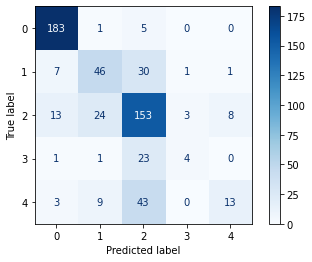

efficientnet_b4 - Epoch 1, Train Loss: 1.2039184727602534, Validation Loss: 1.0200294852256775, Validation Accuracy: 61.53846153846154%
efficientnet_b4 - Epoch 2, Train Loss: 0.9949638537234731, Validation Loss: 0.9315599997838339, Validation Accuracy: 65.55944055944056%
efficientnet_b4 - Epoch 3, Train Loss: 0.9302311663826307, Validation Loss: 0.8890161315600077, Validation Accuracy: 66.95804195804196%
efficientnet_b4 - Epoch 4, Train Loss: 0.8939033647378286, Validation Loss: 0.8628405630588531, Validation Accuracy: 68.88111888111888%
efficientnet_b4 - Epoch 5, Train Loss: 0.8608833253383636, Validation Loss: 0.8423609932263693, Validation Accuracy: 68.88111888111888%
efficientnet_b4 - Epoch 6, Train Loss: 0.8368597817089822, Validation Loss: 0.8241234090593126, Validation Accuracy: 70.62937062937063%
efficientnet_b4 - Epoch 7, Train Loss: 0.8164133719272084, Validation Loss: 0.8121581309371524, Validation Accuracy: 69.58041958041959%
efficientnet_b4 - Epoch 8, Train Loss: 0.8052007

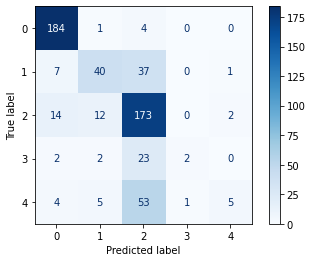

efficientnet_b5 - Epoch 1, Train Loss: 1.1314444202515814, Validation Loss: 1.238843493991428, Validation Accuracy: 47.37762237762238%
efficientnet_b5 - Epoch 2, Train Loss: 0.9179670429892011, Validation Loss: 1.0318740672535367, Validation Accuracy: 60.13986013986014%
efficientnet_b5 - Epoch 3, Train Loss: 0.8673537911640273, Validation Loss: 0.9154635104868147, Validation Accuracy: 65.73426573426573%
efficientnet_b5 - Epoch 4, Train Loss: 0.8094065628117986, Validation Loss: 0.850837402873569, Validation Accuracy: 68.7062937062937%
efficientnet_b5 - Epoch 5, Train Loss: 0.8009853512048721, Validation Loss: 0.8116488522953458, Validation Accuracy: 71.15384615384616%
efficientnet_b5 - Epoch 6, Train Loss: 0.7810326905714141, Validation Loss: 0.7936578426096175, Validation Accuracy: 69.93006993006993%
efficientnet_b5 - Epoch 7, Train Loss: 0.7455964216755496, Validation Loss: 0.7801412575774722, Validation Accuracy: 70.45454545454545%
efficientnet_b5 - Epoch 8, Train Loss: 0.7344862073

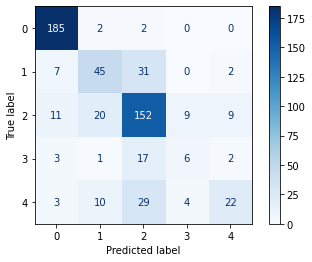

efficientnet_b6 - Epoch 1, Train Loss: 1.141974466542403, Validation Loss: 1.2510380347569783, Validation Accuracy: 42.48251748251748%
efficientnet_b6 - Epoch 2, Train Loss: 0.9172561632262336, Validation Loss: 1.0669027235772874, Validation Accuracy: 58.39160839160839%
efficientnet_b6 - Epoch 3, Train Loss: 0.8402439430356026, Validation Loss: 0.9545597897635566, Validation Accuracy: 63.11188811188811%
efficientnet_b6 - Epoch 4, Train Loss: 0.8192615964346461, Validation Loss: 0.8848638070954217, Validation Accuracy: 65.73426573426573%
efficientnet_b6 - Epoch 5, Train Loss: 0.787850120001369, Validation Loss: 0.8563456469111972, Validation Accuracy: 67.48251748251748%
efficientnet_b6 - Epoch 6, Train Loss: 0.7604237281613879, Validation Loss: 0.8443063100179037, Validation Accuracy: 68.00699300699301%
efficientnet_b6 - Epoch 7, Train Loss: 0.7350083626806736, Validation Loss: 0.8551969296402402, Validation Accuracy: 66.43356643356644%
efficientnet_b6 - Epoch 8, Train Loss: 0.714118709

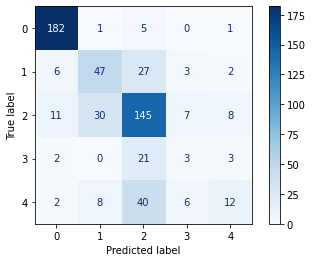

In [13]:
for model_name in efficientnet_variants:
    model = modify_efficientnet(model_name, num_classes=5).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    train_losses, val_losses, val_accuracies = train_and_evaluate(
        model, criterion, optimizer, scheduler, train_loader, val_loader, device
    )
    
    # Load the best model before evaluation
    model.load_state_dict(torch.load(f"{model_name}_best.pth"))

    print(f"Performance Metrics for {model_name}:")
    evaluate_performance(model, val_loader, device)